#Student Name: Bianjiang Yang
#ECE 595 Machine Learning II
#Project 3: GAN - Student Code

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 31 01:56:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Import necessary packages
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


#Part 1: Implementing the GAN

Epoch 10000
10000: [Discriminaotr loss: 0.637556, acc: 0.253906]  [GAN loss: 0.941244, acc: 0.296875]


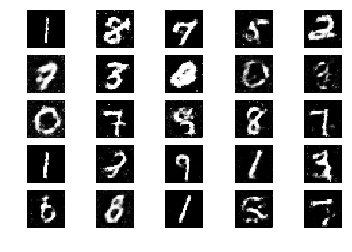

Epoch 20000
20000: [Discriminaotr loss: 0.614925, acc: 0.296875]  [GAN loss: 1.235478, acc: 0.179688]


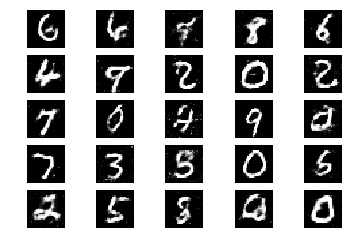

Epoch 30000
30000: [Discriminaotr loss: 0.577874, acc: 0.375000]  [GAN loss: 1.305931, acc: 0.136719]


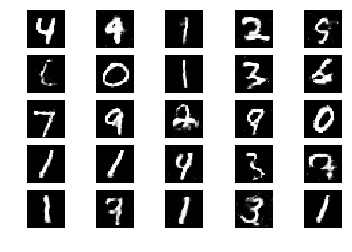

Epoch 40000
40000: [Discriminaotr loss: 0.589523, acc: 0.416016]  [GAN loss: 1.264524, acc: 0.183594]


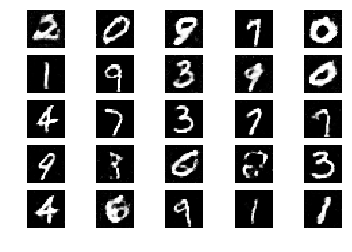

Epoch 50000
50000: [Discriminaotr loss: 0.595455, acc: 0.453125]  [GAN loss: 0.964149, acc: 0.335938]


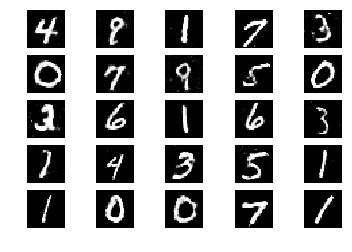

Epoch 60000
60000: [Discriminaotr loss: 0.577193, acc: 0.453125]  [GAN loss: 0.999116, acc: 0.296875]


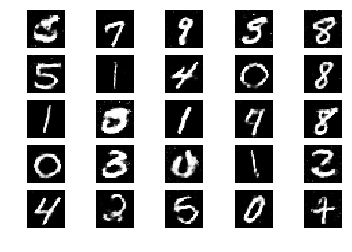

Epoch 70000
70000: [Discriminaotr loss: 0.565976, acc: 0.384766]  [GAN loss: 1.321002, acc: 0.136719]


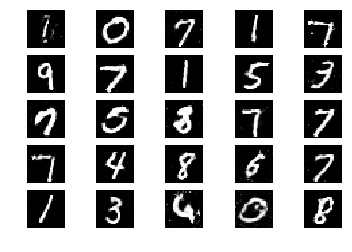

Epoch 80000
80000: [Discriminaotr loss: 0.565203, acc: 0.427734]  [GAN loss: 1.451796, acc: 0.156250]


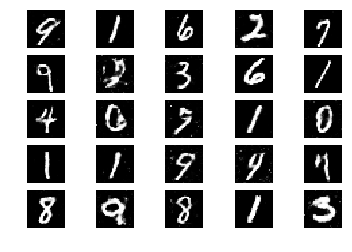

Epoch 90000
90000: [Discriminaotr loss: 0.543349, acc: 0.427734]  [GAN loss: 1.314933, acc: 0.214844]


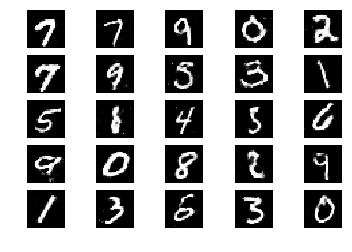

Epoch 100000
100000: [Discriminaotr loss: 0.551921, acc: 0.437500]  [GAN loss: 1.382027, acc: 0.156250]


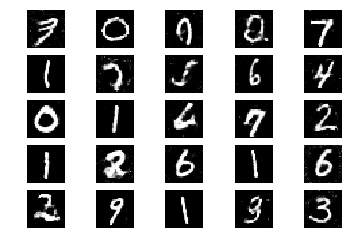

In [ ]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (_, _) = mnist.load_data()
data_train = (data_train.astype(np.float32) - 127.5)/127.5
data_train = data_train.reshape(60000,784)

# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(learning_rate = 0.0002, beta_1 = 0.5,beta_2 = 0.999)

def gan_optimizer():
    return adam(learning_rate = 0.001, beta_1 = 0.9,beta_2 = 0.999)#0.001

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim = latent_dim))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(data_dim, activation = 'tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=gan_optimizer())
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim = data_dim))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dense(1, activation = 'sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=dis_optimizer(), metrics=['accuracy'])

    return discriminator
    

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer(), metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 256
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(low=0, high=data_train.shape[0], size=batch_size)]

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((real_images, fake_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_discriminator = np.zeros(2 * batch_size)
    labels_discriminator[:batch_size] = 0.9

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise_new = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise_new, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

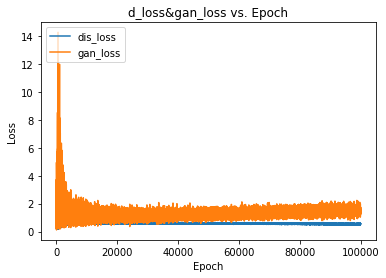

In [ ]:
# Plot model loss vs epoch
#print training_meta_data
plt.plot (training_meta_data[:,0])
plt.plot (training_meta_data[:,1])
plt.title ('d_loss&gan_loss vs. Epoch')
plt.ylabel ('Loss')
plt.xlabel ('Epoch')
plt.legend (['dis_loss','gan_loss'] , loc='upper left')
plt.show()

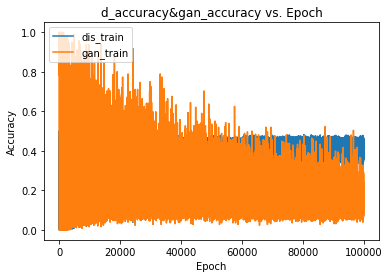

In [ ]:
# Plot accuracy vs epoch
plt.plot (training_meta_data[:,2])
plt.plot (training_meta_data[:,3])
#plt.plot (gan_loss.history [ 'val_accuracy' ] )
plt.title ('d_accuracy&gan_accuracy vs. Epoch')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend (['dis_train','gan_train'] , loc='upper left')
plt.show()

#Part 2: Generating samples using trained generator

In [ ]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
noise = np.random.normal(loc = 0, scale=0.5, size = (10, latent_dim))
gen_imgs = generator.predict(noise)
# Re-scale generated images to lie in [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

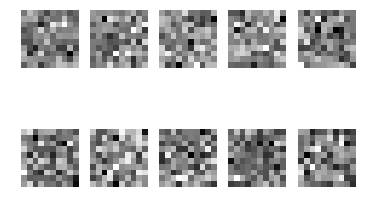

In [ ]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt,:].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

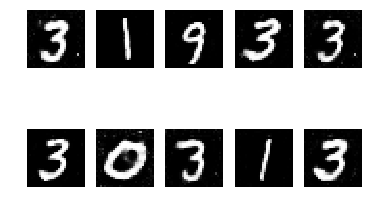

In [ ]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((gen_imgs[cnt,:].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Colab_Notebooks

# Load mnist classifier and generated images
mnist_classifier = load_model('mnist_classifier.h5')

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks


In [ ]:
# ASSIGN CLASSES
labels = [3,1,9,3,3,3,0,3,1,3]

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Show classifications
classifications = mnist_classifier.predict(gen_imgs)
print classifications

# Evaluate accuracy
scores = mnist_classifier.evaluate(gen_imgs, labels)
print "Accuracy: %.2f%%" %(scores[1]*100)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 3.94117730e-29 0.00000000e+00 6.96296463e-37
  0.00000000e+00 3.22934590e-37]
 [1.28937289e-34 1.00000000e+00 3.98507631e-31 1.82681116e-33
  8.19506509e-20 1.33007877e-19 1.69155592e-25 1.65993236e-26
  2.79917532e-20 5.38279067e-33]
 [6.49537508e-29 1.67572977e-26 1.39241296e-25 1.18481058e-10
  3.77417824e-14 1.74801647e-14 9.86867548e-34 3.59073711e-17
  1.13724761e-18 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 1.03988650e-31 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.28477599e-36]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 4.49975048e-35 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 6.42572279e-31 0.00000000e

#Part 1-2: Without Dropout in Discriminator

Epoch 10000
10000: [Discriminaotr loss: 0.540775, acc: 0.412109]  [GAN loss: 1.494833, acc: 0.132812]


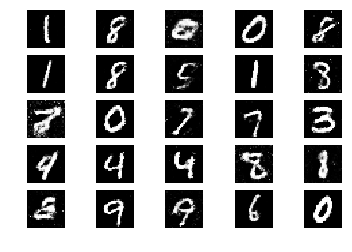

Epoch 20000
20000: [Discriminaotr loss: 0.521632, acc: 0.414062]  [GAN loss: 2.255212, acc: 0.035156]


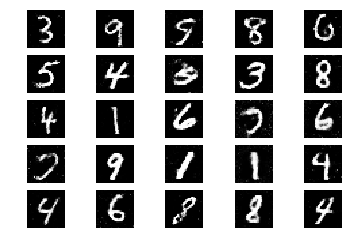

Epoch 30000
30000: [Discriminaotr loss: 0.411876, acc: 0.458984]  [GAN loss: 2.233189, acc: 0.097656]


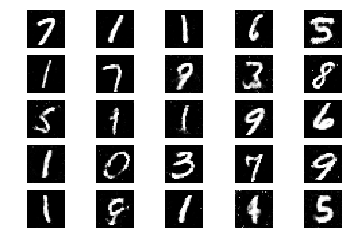

Epoch 40000
40000: [Discriminaotr loss: 0.363261, acc: 0.464844]  [GAN loss: 2.681770, acc: 0.062500]


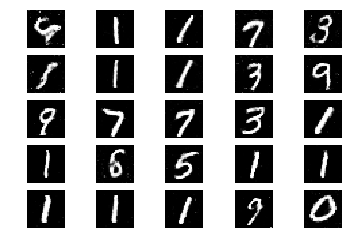

Epoch 50000
50000: [Discriminaotr loss: 0.511118, acc: 0.349609]  [GAN loss: 4.418025, acc: 0.023438]


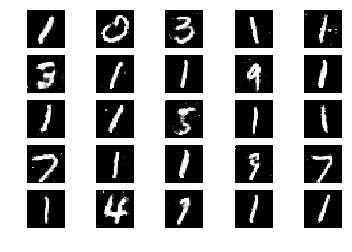

Epoch 60000
60000: [Discriminaotr loss: 0.295772, acc: 0.490234]  [GAN loss: 3.268726, acc: 0.039062]


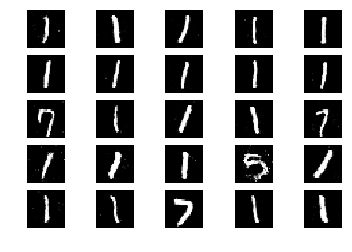

Epoch 70000
70000: [Discriminaotr loss: 0.277167, acc: 0.488281]  [GAN loss: 5.166409, acc: 0.007812]


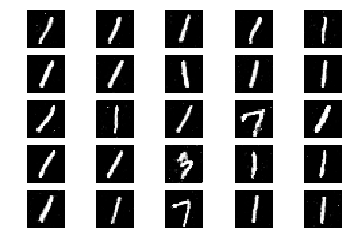

Epoch 80000
80000: [Discriminaotr loss: 0.275975, acc: 0.500000]  [GAN loss: 3.036888, acc: 0.000000]


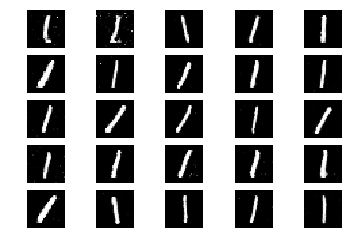

Epoch 90000
90000: [Discriminaotr loss: 0.258914, acc: 0.492188]  [GAN loss: 3.052401, acc: 0.007812]


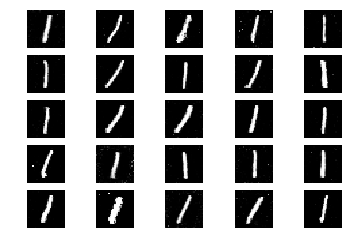

Epoch 100000
100000: [Discriminaotr loss: 0.242633, acc: 0.492188]  [GAN loss: 4.164649, acc: 0.000000]


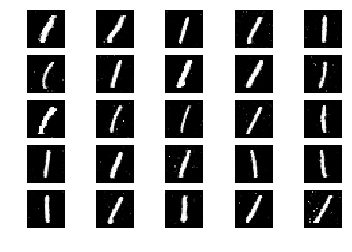

In [ ]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (_, _) = mnist.load_data()
data_train = (data_train.astype(np.float32) - 127.5)/127.5
data_train = data_train.reshape(60000,784)

# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(learning_rate = 0.0002, beta_1 = 0.5,beta_2 = 0.999)

def gan_optimizer():
    return adam(learning_rate = 0.001, beta_1 = 0.9,beta_2 = 0.999)#0.001

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim = latent_dim))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(data_dim, activation = 'tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=gan_optimizer())
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim = data_dim))
    discriminator.add(LeakyReLU(0.1))
    #discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.1))
    #discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dense(1, activation = 'sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=dis_optimizer(), metrics=['accuracy'])

    return discriminator
    

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer(), metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 256
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(low=0, high=data_train.shape[0], size=batch_size)]

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((real_images, fake_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_discriminator = np.zeros(2 * batch_size)
    labels_discriminator[:batch_size] = 0.9

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise_new = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise_new, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

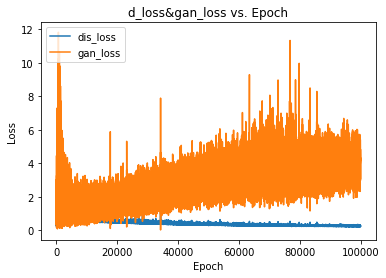

In [ ]:
# Plot model loss vs epoch
#print training_meta_data
plt.plot (training_meta_data[:,0])
plt.plot (training_meta_data[:,1])
plt.title ('d_loss&gan_loss vs. Epoch')
plt.ylabel ('Loss')
plt.xlabel ('Epoch')
plt.legend (['dis_loss','gan_loss'] , loc='upper left')
plt.show()

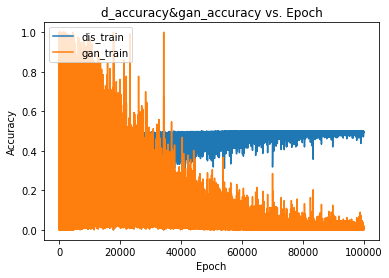

In [ ]:
# Plot accuracy vs epoch
plt.plot (training_meta_data[:,2])
plt.plot (training_meta_data[:,3])
#plt.plot (gan_loss.history [ 'val_accuracy' ] )
plt.title ('d_accuracy&gan_accuracy vs. Epoch')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend (['dis_train','gan_train'] , loc='upper left')
plt.show()

#Part 1-3: With Dropout 0.2 in Discriminator

Epoch 10000
10000: [Discriminaotr loss: 0.585265, acc: 0.300781]  [GAN loss: 1.908310, acc: 0.050781]


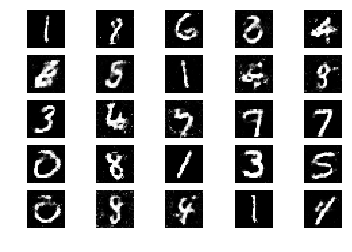

Epoch 20000
20000: [Discriminaotr loss: 0.595022, acc: 0.376953]  [GAN loss: 1.252540, acc: 0.210938]


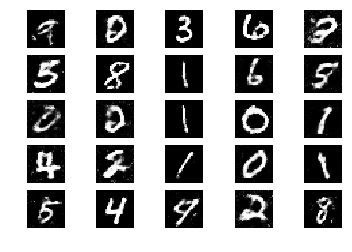

Epoch 30000
30000: [Discriminaotr loss: 0.558026, acc: 0.474609]  [GAN loss: 1.055712, acc: 0.265625]


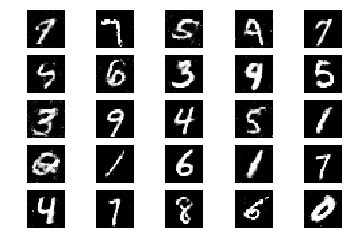

Epoch 40000
40000: [Discriminaotr loss: 0.544713, acc: 0.398438]  [GAN loss: 1.543350, acc: 0.121094]


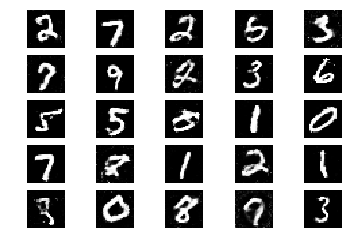

Epoch 50000
50000: [Discriminaotr loss: 0.521978, acc: 0.425781]  [GAN loss: 1.457722, acc: 0.156250]


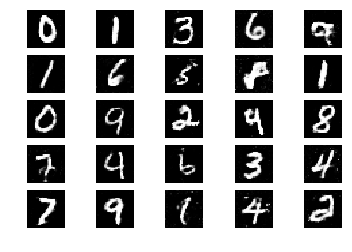

Epoch 60000
60000: [Discriminaotr loss: 0.565691, acc: 0.412109]  [GAN loss: 1.402515, acc: 0.167969]


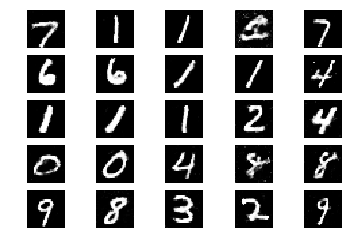

Epoch 70000
70000: [Discriminaotr loss: 0.521408, acc: 0.445312]  [GAN loss: 1.613731, acc: 0.117188]


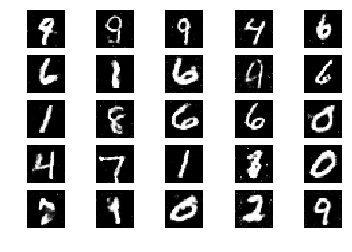

Epoch 80000
80000: [Discriminaotr loss: 0.498722, acc: 0.431641]  [GAN loss: 1.860284, acc: 0.113281]


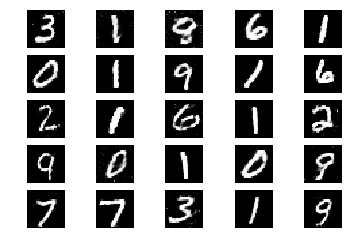

Epoch 90000
90000: [Discriminaotr loss: 0.476966, acc: 0.390625]  [GAN loss: 2.224389, acc: 0.050781]


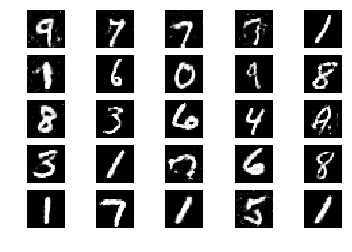

Epoch 100000
100000: [Discriminaotr loss: 0.467175, acc: 0.437500]  [GAN loss: 1.884441, acc: 0.113281]


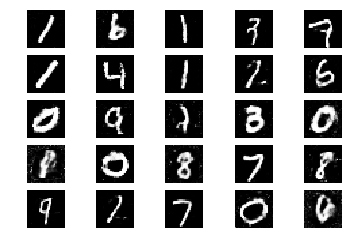

In [ ]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (_, _) = mnist.load_data()
data_train = (data_train.astype(np.float32) - 127.5)/127.5
data_train = data_train.reshape(60000,784)

# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(learning_rate = 0.0002, beta_1 = 0.5,beta_2 = 0.999)

def gan_optimizer():
    return adam(learning_rate = 0.001, beta_1 = 0.9,beta_2 = 0.999)#0.001

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim = latent_dim))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(data_dim, activation = 'tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=gan_optimizer())
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim = data_dim))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dense(1, activation = 'sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=dis_optimizer(), metrics=['accuracy'])

    return discriminator
    

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer(), metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 256
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(low=0, high=data_train.shape[0], size=batch_size)]

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((real_images, fake_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_discriminator = np.zeros(2 * batch_size)
    labels_discriminator[:batch_size] = 0.9

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise_new = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise_new, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

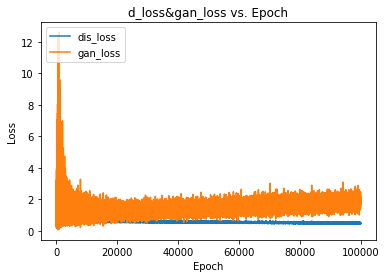

In [ ]:
# Plot model loss vs epoch
#print training_meta_data
plt.plot (training_meta_data[:,0])
plt.plot (training_meta_data[:,1])
plt.title ('d_loss&gan_loss vs. Epoch')
plt.ylabel ('Loss')
plt.xlabel ('Epoch')
plt.legend (['dis_loss','gan_loss'] , loc='upper left')
plt.show()

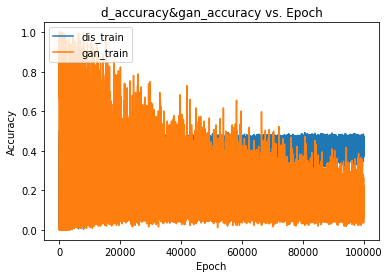

In [ ]:
# Plot accuracy vs epoch
plt.plot (training_meta_data[:,2])
plt.plot (training_meta_data[:,3])
#plt.plot (gan_loss.history [ 'val_accuracy' ] )
plt.title ('d_accuracy&gan_accuracy vs. Epoch')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend (['dis_train','gan_train'] , loc='upper left')
plt.show()

#Part 1-4: With Dropout 0.4 in Discriminator

11501568/11490434 [==============================] - 0s 0us/step
Epoch 10000
10000: [Discriminaotr loss: 0.628112, acc: 0.396484]  [GAN loss: 1.323811, acc: 0.117188]


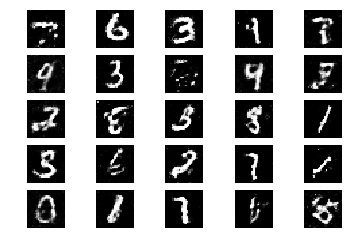

Epoch 20000
20000: [Discriminaotr loss: 0.620976, acc: 0.433594]  [GAN loss: 0.960496, acc: 0.253906]


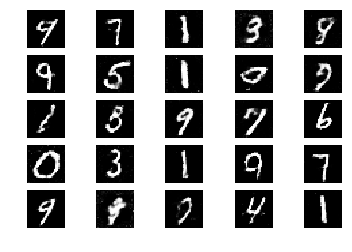

Epoch 30000
30000: [Discriminaotr loss: 0.609081, acc: 0.394531]  [GAN loss: 1.108358, acc: 0.191406]


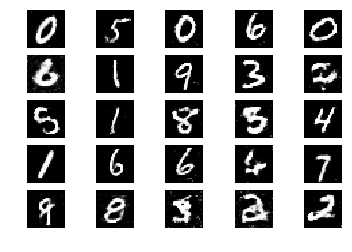

Epoch 40000
40000: [Discriminaotr loss: 0.614889, acc: 0.414062]  [GAN loss: 1.112262, acc: 0.234375]


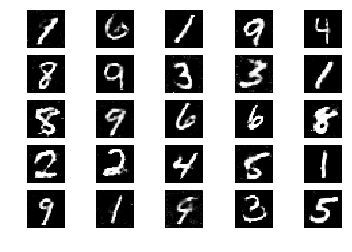

Epoch 50000
50000: [Discriminaotr loss: 0.612703, acc: 0.396484]  [GAN loss: 1.041993, acc: 0.238281]


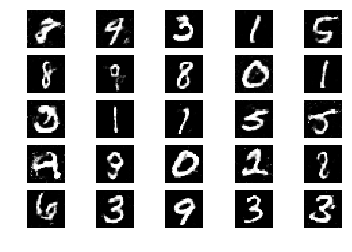

Epoch 60000
60000: [Discriminaotr loss: 0.587538, acc: 0.449219]  [GAN loss: 1.107104, acc: 0.183594]


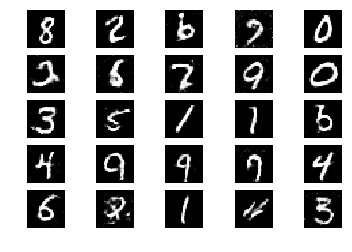

Epoch 70000
70000: [Discriminaotr loss: 0.601446, acc: 0.421875]  [GAN loss: 1.065724, acc: 0.222656]


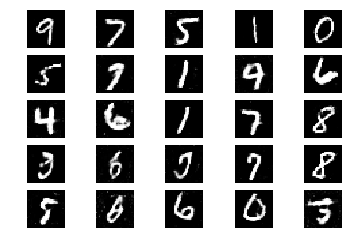

Epoch 80000
80000: [Discriminaotr loss: 0.566260, acc: 0.404297]  [GAN loss: 1.148947, acc: 0.207031]


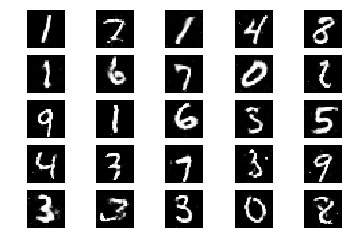

Epoch 90000
90000: [Discriminaotr loss: 0.575824, acc: 0.410156]  [GAN loss: 1.233106, acc: 0.199219]


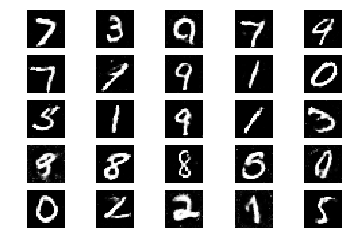

Epoch 100000
100000: [Discriminaotr loss: 0.595267, acc: 0.339844]  [GAN loss: 1.208895, acc: 0.187500]


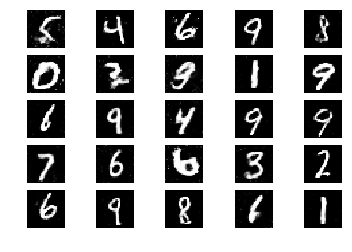

In [ ]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (_, _) = mnist.load_data()
data_train = (data_train.astype(np.float32) - 127.5)/127.5
data_train = data_train.reshape(60000,784)

# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(learning_rate = 0.0002, beta_1 = 0.5,beta_2 = 0.999)

def gan_optimizer():
    return adam(learning_rate = 0.001, beta_1 = 0.9,beta_2 = 0.999)#0.001

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim = latent_dim))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(data_dim, activation = 'tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=gan_optimizer())
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim = data_dim))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dense(1, activation = 'sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=dis_optimizer(), metrics=['accuracy'])

    return discriminator
    

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer(), metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 256
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(low=0, high=data_train.shape[0], size=batch_size)]

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((real_images, fake_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_discriminator = np.zeros(2 * batch_size)
    labels_discriminator[:batch_size] = 0.9

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise_new = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise_new, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

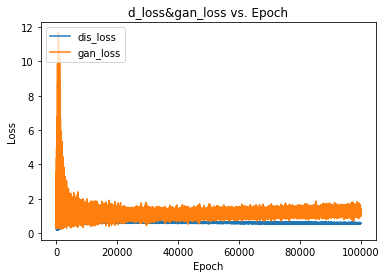

In [ ]:
# Plot model loss vs epoch
#print training_meta_data
plt.plot (training_meta_data[:,0])
plt.plot (training_meta_data[:,1])
plt.title ('d_loss&gan_loss vs. Epoch')
plt.ylabel ('Loss')
plt.xlabel ('Epoch')
plt.legend (['dis_loss','gan_loss'] , loc='upper left')
plt.show()

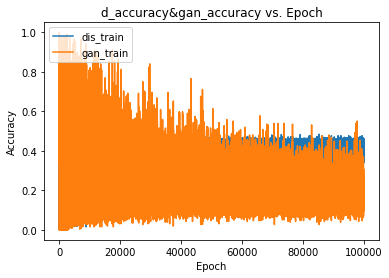

In [ ]:
# Plot accuracy vs epoch
plt.plot (training_meta_data[:,2])
plt.plot (training_meta_data[:,3])
#plt.plot (gan_loss.history [ 'val_accuracy' ] )
plt.title ('d_accuracy&gan_accuracy vs. Epoch')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend (['dis_train','gan_train'] , loc='upper left')
plt.show()

# Bonus: Other Hyperparameter Settings

Epoch 10000
10000: [Discriminaotr loss: 0.589101, acc: 0.388672]  [GAN loss: 1.218766, acc: 0.164062]


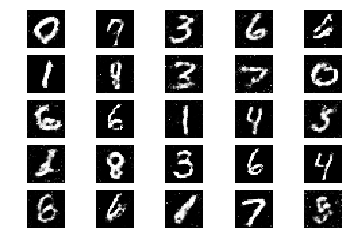

Epoch 20000
20000: [Discriminaotr loss: 0.587559, acc: 0.431641]  [GAN loss: 1.128841, acc: 0.144531]


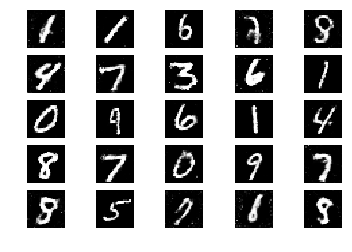

Epoch 30000
30000: [Discriminaotr loss: 0.594106, acc: 0.400391]  [GAN loss: 1.296557, acc: 0.089844]


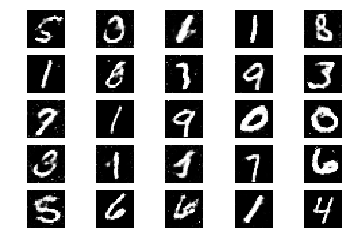

Epoch 40000
40000: [Discriminaotr loss: 0.584512, acc: 0.416016]  [GAN loss: 1.160285, acc: 0.167969]


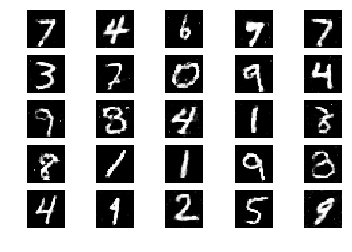

Epoch 50000
50000: [Discriminaotr loss: 0.567543, acc: 0.388672]  [GAN loss: 1.251637, acc: 0.125000]


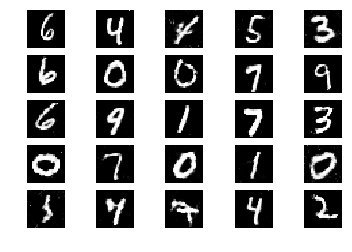

Epoch 60000
60000: [Discriminaotr loss: 0.575475, acc: 0.431641]  [GAN loss: 1.135825, acc: 0.195312]


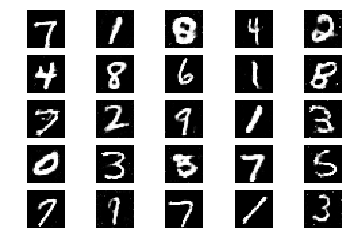

Epoch 70000
70000: [Discriminaotr loss: 0.579782, acc: 0.421875]  [GAN loss: 1.167985, acc: 0.179688]


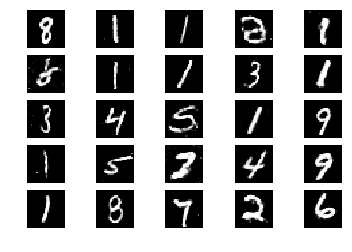

Epoch 80000
80000: [Discriminaotr loss: 0.604988, acc: 0.402344]  [GAN loss: 1.270902, acc: 0.117188]


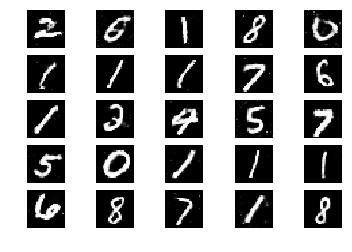

Epoch 90000
90000: [Discriminaotr loss: 0.569577, acc: 0.429688]  [GAN loss: 1.305946, acc: 0.113281]


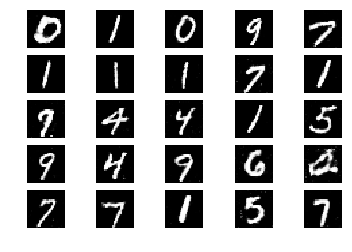

Epoch 100000
100000: [Discriminaotr loss: 0.580879, acc: 0.451172]  [GAN loss: 1.295050, acc: 0.160156]


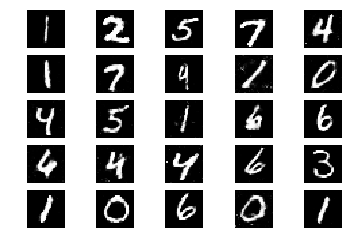

In [ ]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (_, _) = mnist.load_data()
data_train = (data_train.astype(np.float32) - 127.5)/127.5
data_train = data_train.reshape(60000,784)

# The D-dimensional noise vector length
latent_dim = 100
data_dim = 784

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999)

def gan_optimizer():
    return adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999)

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim = latent_dim))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(data_dim, activation = 'tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=gan_optimizer())
    return generator

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim = data_dim))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.1))
    discriminator.add(Dense(1, activation = 'sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=dis_optimizer(), metrics=['accuracy'])

    return discriminator
    

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=gan_optimizer(), metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 256
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(low=0, high=data_train.shape[0], size=batch_size)]

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate((real_images, fake_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_discriminator = np.zeros(2 * batch_size)
    labels_discriminator[:batch_size] = 0.9

    # Allow discriminator parameters to be updated
    discriminator.trainable = True

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise_new = np.random.normal(loc = 0, scale=1, size = (batch_size, latent_dim))
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise_new, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

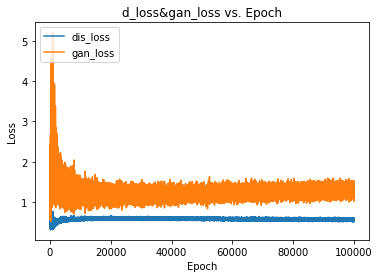

In [ ]:
# Plot model loss vs epoch
#print training_meta_data
plt.plot (training_meta_data[:,0])
plt.plot (training_meta_data[:,1])
plt.title ('d_loss&gan_loss vs. Epoch')
plt.ylabel ('Loss')
plt.xlabel ('Epoch')
plt.legend (['dis_loss','gan_loss'] , loc='upper left')
plt.show()

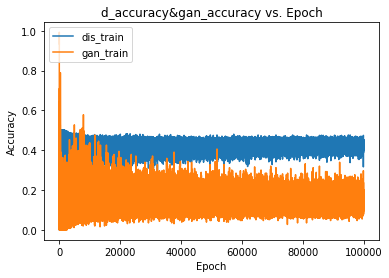

In [ ]:
# Plot accuracy vs epoch
plt.plot (training_meta_data[:,2])
plt.plot (training_meta_data[:,3])
#plt.plot (gan_loss.history [ 'val_accuracy' ] )
plt.title ('d_accuracy&gan_accuracy vs. Epoch')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')
plt.legend (['dis_train','gan_train'] , loc='upper left')
plt.show()

[4]. Compare and comment on the results of GAN with dropout and without dropout.

ANS: The result with dropout is better because they can generate more general digits' images. However, without dropout, most digits are "1", which indicates without dropout training leads to overfitting and less generalization. According to the GAN Loss figure from the without-dropout model, we can also draw this conclusion because the loss increased finally.

[5][a]. Comment on importance of hyper-parameter tuning

As shown in part1-3 and part1-4, I increased and decreased the dropout rate by 0.1. So overall I have dropout rate results of [0.2, 0.3, 0.4]. 

Dropout 0.2 [Discriminaotr loss: 0.467175, acc: 0.437500] [GAN loss: 1.884441, acc: 0.113281]

Dropout 0.3 [Discriminaotr loss: 0.551921, acc: 0.437500] [GAN loss: 1.382027, acc: 0.156250]

Dropout 0.4 [Discriminaotr loss: 0.595267, acc: 0.339844] [GAN loss: 1.208895, acc: 0.187500]

According to the 100000 epoch result, dropout 0.4 model has the best performance for generator because the GAN loss is the lowest and the GAN accuracy is the highest. If observing the figure of the gan loss, it's obvious that dropout 0.2 model is still overfitting. 

[b] Bonus: Find other hyperparameter settings which produce similar or better results than 1.

I decreased the learning rate of gan_optimizer to the same as the dis_optimizer's. The final result is:

Dropout 0.3 with gan_lr=0.00002 [Discriminaotr loss: 0.580879, acc: 0.451172]  [GAN loss: 1.295050, acc: 0.160156]

Dropout 0.3 with gan_lr=0.0001 [Discriminaotr loss: 0.551921, acc: 0.437500] [GAN loss: 1.382027, acc: 0.156250]

So it's obvious the gan loss is decreased and the gan accuracy is increased. So it has the better performance than the original model. I think it's basically because: even if with dropout rate 0.3, the model is still faced with overfitting problem. However, I decreased the learning rate, which provides a way to overcome overfitting problem. And it works.

[6]. Answer the following questions:


1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  ANS: I think it's a good trait of the GAN. Because we need the discriminator and generator to learn one after another. More importantly, they should be as strong as the other model so that both of them can be trained thoroughly. So if the discriminator accuracy is 50%, which means the discriminator is as strong as the generator, both of them are try to learn better to beat the other. Finally, we can get a strong enough generator.


2.   How could this model be modified to produce cleaner (less noisy) images? 

  ANS: To produce cleaner images, we need the generator to be able to learn more detailed information from MNIST. So a possible solution is to enlarge the generator by adding more layers and channels to increase the complexity. We also need to increase the complexity of the discriminator at the same time so that it can help generator to train.



3. Answer the following questions:

a) State the accuracy of the classifier on your ten generated images. Based on this accuracy, would you say your generator does well in producing images comparable to those in the MNIST dataset of hand-written digits? Why or why not?

The accuracy is 100%.

Yes, I think the generator does well. Because the experiment results indicate that the classifier trained on MNIST can accurately classify the generated fake images to 10 categories. 

b) In this project, we only tested the performance of the pre-trained classifier on ten samples and used its result to determine the robustness of the generator. How could we better assess the quality of the generated images using this pre-trained classifier and the saved generator?

(1) We can generate more samples and use the classifier to classify them and calculate the accuracy to see if the generated images has a good quality.
(2) We can also use some MNIST test data to test and compare the accuracy with the generated images. 